In [5]:
import argparse
from pathlib import Path

import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import mlflow
import mlflow.sklearn
import mlflow.pyfunc
from mlflow.tracking import MlflowClient

In [6]:
TARGET_COL = "cost"

NUMERIC_COLS = [
    "distance", "dropoff_latitude", "dropoff_longitude", "passengers", "pickup_latitude",
    "pickup_longitude", "pickup_weekday", "pickup_month", "pickup_monthday", "pickup_hour",
    "pickup_minute", "pickup_second", "dropoff_weekday", "dropoff_month", "dropoff_monthday",
    "dropoff_hour", "dropoff_minute", "dropoff_second"
]

CAT_NOM_COLS = [
    "store_forward", "vendor"
]

CAT_ORD_COLS = [
]


In [7]:
# Define Arguments for this step

class MyArgs:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

args = MyArgs(
                model_name = "taxi-model",
                model_input = "/tmp/train",
                test_data = "/tmp/prep/test",
                evaluation_output = "/tmp/evaluate"
                )

os.makedirs(args.evaluation_output, exist_ok = True)

In [8]:

def main(args):
    '''Read trained model and test dataset, evaluate model and save result'''

    # Load the test data
    test_data = pd.read_parquet(Path(args.test_data)/"test.parquet")

    # Split the data into inputs and outputs
    y_test = test_data[TARGET_COL]
    X_test = test_data[NUMERIC_COLS + CAT_NOM_COLS + CAT_ORD_COLS]

    # Load the model from input port
    model =  mlflow.sklearn.load_model(args.model_input) 

    # ---------------- Model Evaluation ---------------- #
    yhat_test, score = model_evaluation(X_test, y_test, model, args.evaluation_output)

    # ----------------- Model Promotion ---------------- #
    predictions, deploy_flag = model_promotion(args.model_name, args.evaluation_output, X_test, y_test, yhat_test, score)



def model_evaluation(X_test, y_test, model, evaluation_output):

    # Get predictions to y_test (y_test)
    yhat_test = model.predict(X_test)

    # Save the output data with feature columns, predicted cost, and actual cost in csv file
    output_data = X_test.copy()
    output_data["real_label"] = y_test
    output_data["predicted_label"] = yhat_test
    output_data.to_csv((Path(evaluation_output) / "predictions.csv"))

    # Evaluate Model performance with the test set
    r2 = r2_score(y_test, yhat_test)
    mse = mean_squared_error(y_test, yhat_test)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, yhat_test)

    # Print score report to a text file
    (Path(evaluation_output) / "score.txt").write_text(
        f"Scored with the following model:\n{format(model)}"
    )
    with open((Path(evaluation_output) / "score.txt"), "a") as outfile:
        outfile.write("Mean squared error: {mse.2f} \n")
        outfile.write("Root mean squared error: {rmse.2f} \n")
        outfile.write("Mean absolute error: {mae.2f} \n")
        outfile.write("Coefficient of determination: {r2.2f} \n")

    mlflow.log_metric("test r2", r2)
    mlflow.log_metric("test mse", mse)
    mlflow.log_metric("test rmse", rmse)
    mlflow.log_metric("test mae", mae)

    # Visualize results
    plt.scatter(y_test, yhat_test,  color='black')
    plt.plot(y_test, y_test, color='blue', linewidth=3)
    plt.xlabel("Real value")
    plt.ylabel("Predicted value")
    plt.title("Comparing Model Predictions to Real values - Test Data")
    plt.savefig("predictions.png")
    mlflow.log_artifact("predictions.png")

    return yhat_test, r2

def model_promotion(model_name, evaluation_output, X_test, y_test, yhat_test, score):
    
    scores = {}
    predictions = {}

    client = MlflowClient()

    for model_run in client.search_model_versions(f"name='{model_name}'"):
        model_version = model_run.version
        mdl = mlflow.pyfunc.load_model(
            model_uri=f"models:/{model_name}/{model_version}")
        predictions[f"{model_name}:{model_version}"] = mdl.predict(X_test)
        scores[f"{model_name}:{model_version}"] = r2_score(
            y_test, predictions[f"{model_name}:{model_version}"])

    if scores:
        if score >= max(list(scores.values())):
            deploy_flag = 1
        else:
            deploy_flag = 0
    else:
        deploy_flag = 1
    print(f"Deploy flag: {deploy_flag}")

    with open((Path(evaluation_output) / "deploy_flag"), 'w') as outfile:
        outfile.write(f"{int(deploy_flag)}")

    # add current model score and predictions
    scores["current model"] = score
    predictions["currrent model"] = yhat_test

    perf_comparison_plot = pd.DataFrame(
        scores, index=["r2 score"]).plot(kind='bar', figsize=(15, 10))
    perf_comparison_plot.figure.savefig("perf_comparison.png")
    perf_comparison_plot.figure.savefig(Path(evaluation_output) / "perf_comparison.png")

    mlflow.log_metric("deploy flag", bool(deploy_flag))
    mlflow.log_artifact("perf_comparison.png")

    return predictions, deploy_flag

Model name: taxi-model
Model path: /tmp/train
Test data path: /tmp/prep/test
Evaluation output path: /tmp/evaluate
artifact uri: file:///c:/Users/heenarefai/Documents/code/mlops-v2-workshop/notebooks/mlruns/775451619847611530/76965ff25e9547ed98ffe4906b9e4bd6/artifacts
Deploy flag: 1


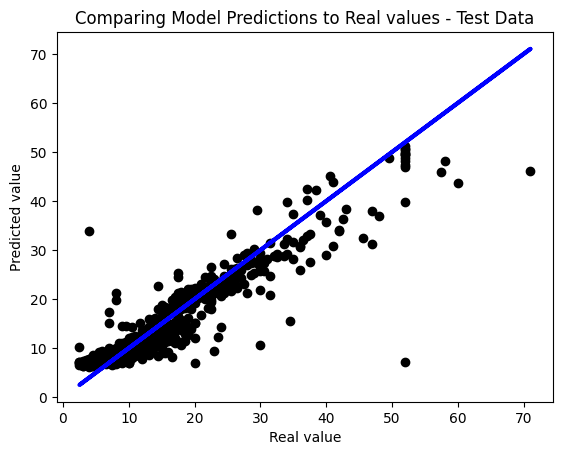

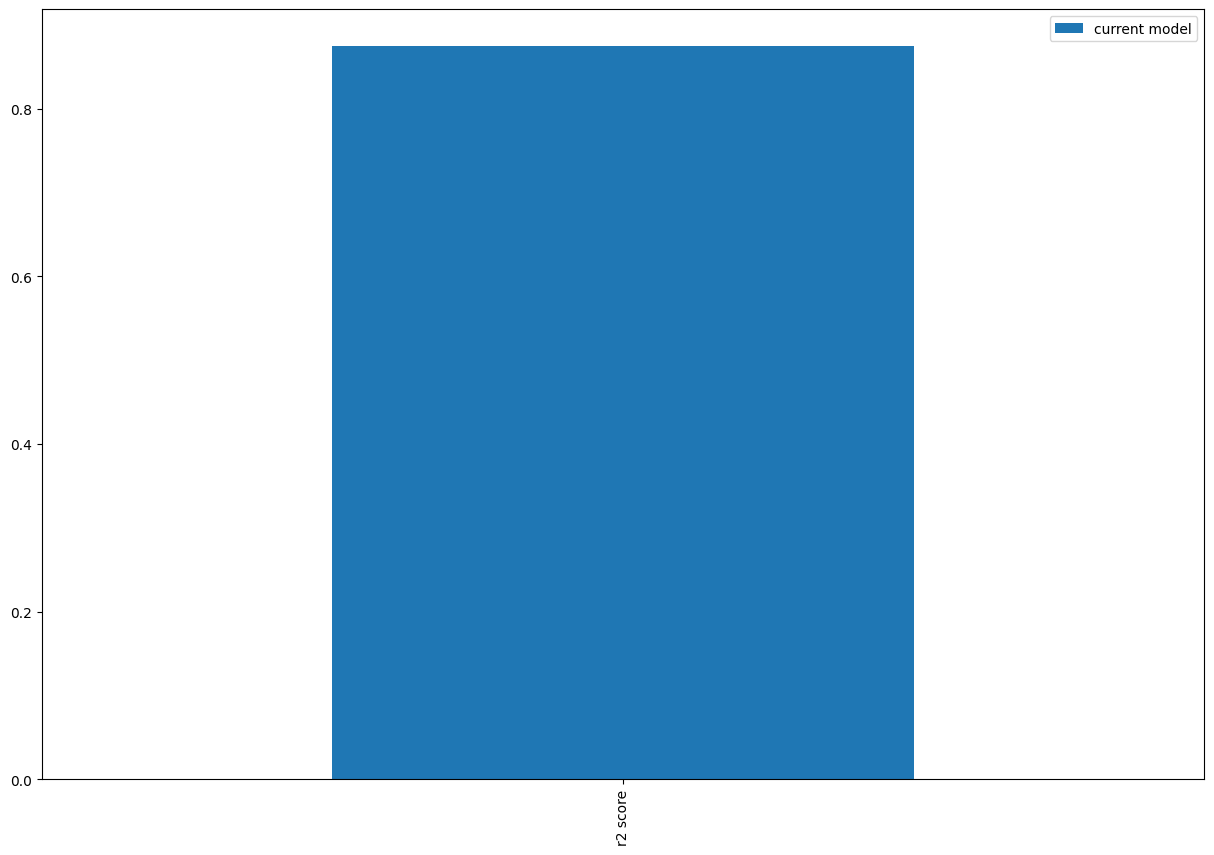

In [9]:

lines = [
    f"Model name: {args.model_name}",
    f"Model path: {args.model_input}",
    f"Test data path: {args.test_data}",
    f"Evaluation output path: {args.evaluation_output}",
]

for line in lines:
    print(line)

### !!!! TODO !! Replace ith your name `my-experiment-john`
mlflow.set_experiment("heena-test")
with mlflow.start_run(run_name="evaluate-nyc"):
  print('artifact uri:', mlflow.get_artifact_uri())  
  main(args)

mlflow.end_run()

In [10]:
ls "/tmp/evaluate"

 Volume in drive C has no label.
 Volume Serial Number is DC19-76FD

 Directory of c:\tmp\evaluate

08/07/2025  14:03    <DIR>          .
08/07/2025  14:02    <DIR>          ..
08/07/2025  14:03                 1 deploy_flag
08/07/2025  14:03            14.639 perf_comparison.png
08/07/2025  14:03           204.452 predictions.csv
08/07/2025  14:03               328 score.txt
               4 File(s)        219.420 bytes
               2 Dir(s)  774.319.325.184 bytes free
